In [61]:
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df = pd.read_csv('/content/drive/MyDrive/medical_cost.csv', low_memory=False); df

,Id,age,sex,bmi,children,smoker,region,charges
0,1,19,female,27.900,0,yes,southwest,16884.92400
1,2,18,male,33.770,1,no,southeast,1725.55230
2,3,28,male,33.000,3,no,southeast,4449.46200
3,4,33,male,22.705,0,no,northwest,21984.47061
4,5,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,1334,50,male,30.970,3,no,northwest,10600.54830
1334,1335,18,female,31.920,0,no,northeast,2205.98080
1335,1336,18,female,36.850,0,no,southeast,1629.83350
1336,1337,21,female,25.800,0,no,southwest,2007.94500


In [64]:
df = df.drop('Id', axis = 1); df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# EDA

In [65]:
var = ['age',	'bmi',	'children',	'charges']
for v in var:
  a = df[v].min()
  b = df[v].max()
  print(f'For {v}: min is {a} and max is {b}')


For age: min is 18 and max is 64
For bmi: min is 15.96 and max is 53.13
For children: min is 0 and max is 5
For charges: min is 1121.8739 and max is 63770.42801


<Axes: xlabel='charges', ylabel='Density'>

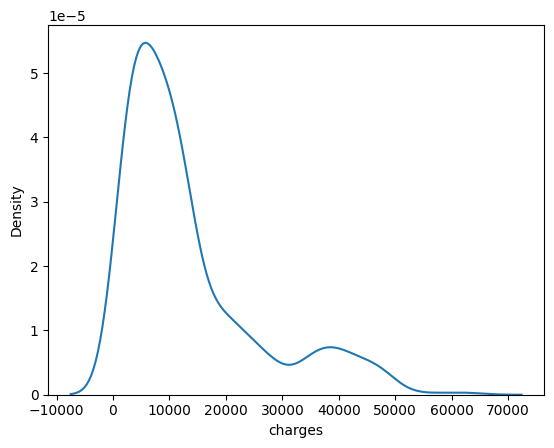

In [66]:
sns.kdeplot( df['charges'])

Mean: 13270.42, Standard Deviation: 12105.48
Lower Bound: -23046.03, Upper Bound: 49586.88
Number of Outliers: 7


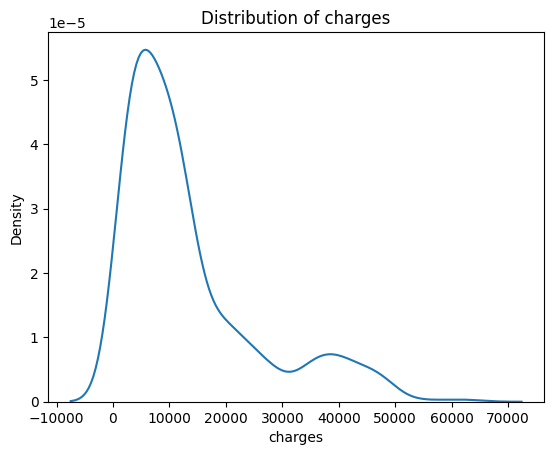

In [67]:
#3 sigma selection for original

data = df['charges']

mean = np.mean(data)
std = np.std(data)

lower_bound = mean - 3*std
upper_bound = mean + 3*std
outliers = [x for x in data if x < lower_bound or x > upper_bound]

print(f"Mean: {mean:.2f}, Standard Deviation: {std:.2f}")
print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
print(f"Number of Outliers: {len(outliers)}")

# Create density plot
sns.kdeplot(data=df, x="charges")

plt.xlabel("charges")
plt.ylabel("Density")
plt.title("Distribution of charges")

plt.show()

We decided to leave only charges <= 50000 based on 3-sigma analyse

In [68]:
df = df[lambda x: x.charges <= 50000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1331 non-null   int64  
 1   sex       1331 non-null   object 
 2   bmi       1331 non-null   float64
 3   children  1331 non-null   int64  
 4   smoker    1331 non-null   object 
 5   region    1331 non-null   object 
 6   charges   1331 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.2+ KB


<ipython-input-69-adec1510efe6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_table = df.corr()


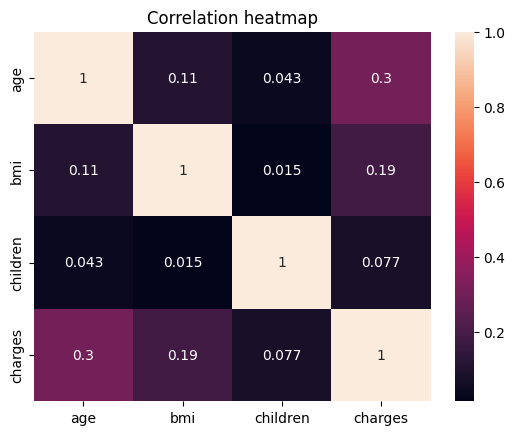

In [69]:
corr_table = df.corr()
sns.heatmap(corr_table, annot=True)
plt.title(f"Correlation heatmap")
plt.show()

The correlation matrix states that there is no multicolinearity between vaibles, so we may not exclude any of them.

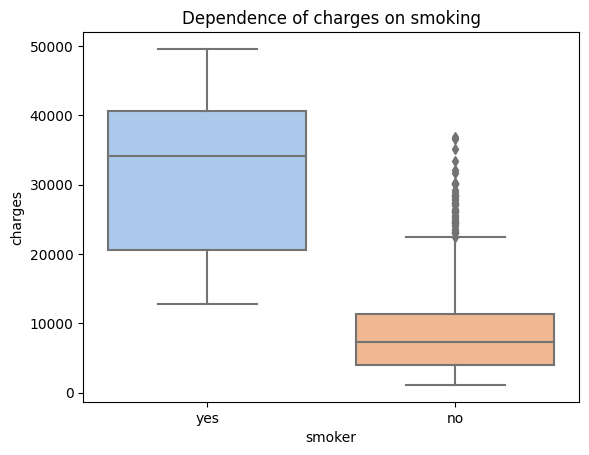

In [70]:
sns.boxplot(data=df, x = df['smoker'], y = df['charges'], palette = "pastel")
plt.title('Dependence of charges on smoking')
plt.show()

This plot shows that for smokers mean value for charges is much higher that for no smoking people.

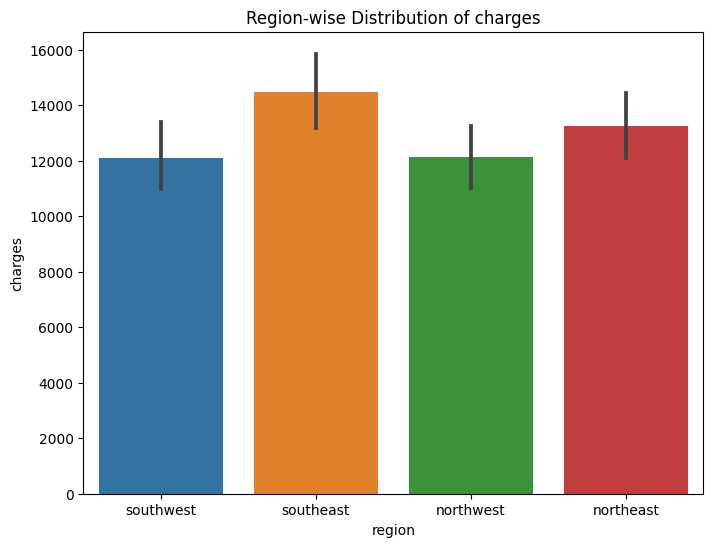

In [71]:
plt.figure(figsize=(8, 6))
sns.barplot(data = df, x = df['region'],y = df['charges'])
plt.title('Region-wise Distribution of charges')
plt.show()

Charges are practically the same, so the difference in region variables is practically insignificant.


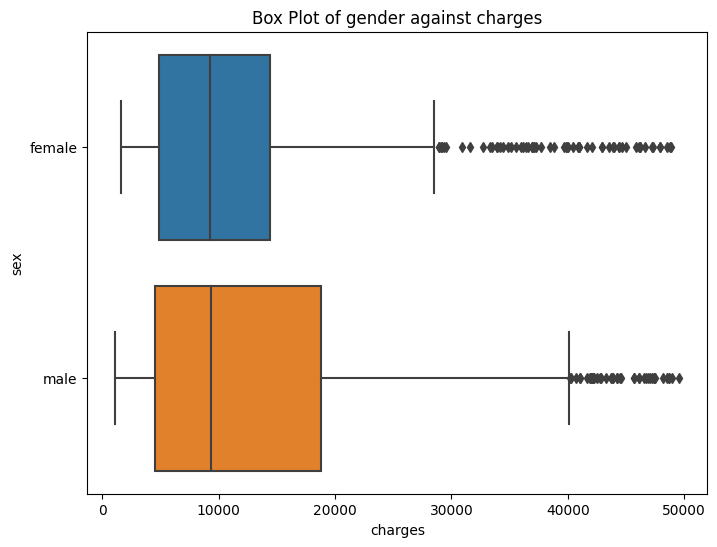

In [72]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='charges', y= 'sex')
plt.title(f"Box Plot of gender against charges")
plt.show()

Women have a greater spread in expenses than men, although the median is about the same level - boxplot.


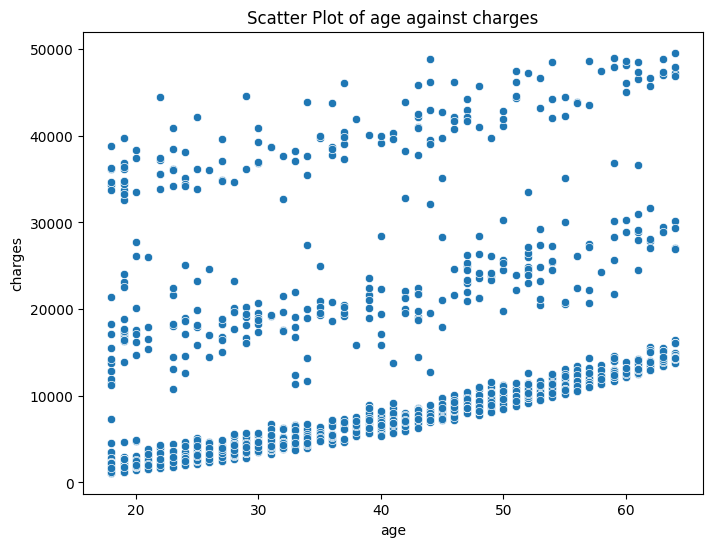

In [73]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="age", y='charges')
plt.title(f"Scatter Plot of age against charges")
plt.show()

This plot shows linear relation between age and charges divided into 3 layers

<ipython-input-74-616e3bd502dc>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data = df, x = df['children'], y = df['charges'], hue = "sex", ci = None)


Text(0.5, 1.0, 'Amount of children distribution of charges by Gender')

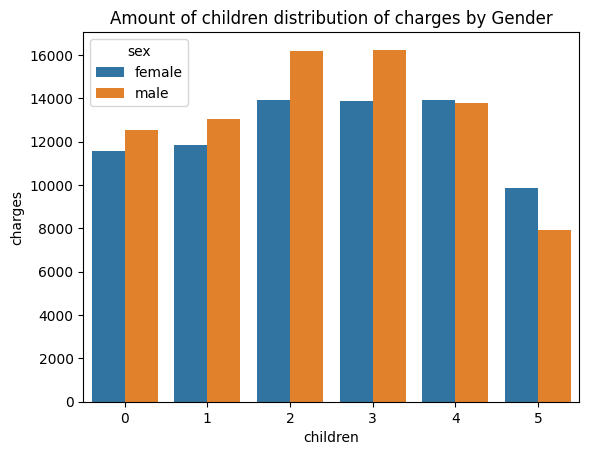

In [74]:
sns.barplot(data = df, x = df['children'], y = df['charges'], hue = "sex", ci = None)
plt.title('Amount of children distribution of charges by Gender')

This plot shows that for both genders charges increase with the number of children until 3 children and then decrease.

Text(0.5, 1.0, 'Effect of bmi om charges')

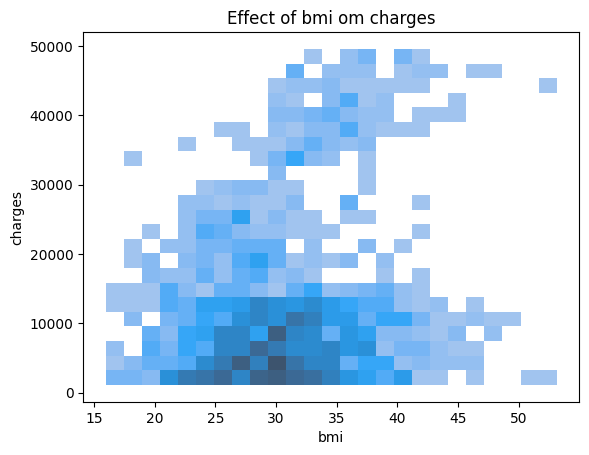

In [75]:
sns.histplot(data = df, x = df['bmi'], y = df['charges'],kde=True)
plt.title('Effect of bmi om charges')

This plot shows non-linear relation between bmi and charges.

<Axes: xlabel='charges', ylabel='Density'>

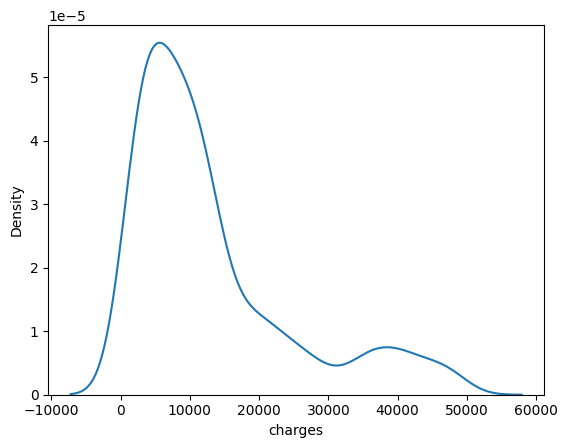

In [76]:
sns.kdeplot(data = df, x = 'charges')

This plot ensures, that we have correctly detected outliers.

# Start

In [77]:
df = df[lambda x: x.charges <= 50000]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1331 non-null   int64  
 1   sex       1331 non-null   object 
 2   bmi       1331 non-null   float64
 3   children  1331 non-null   int64  
 4   smoker    1331 non-null   object 
 5   region    1331 non-null   object 
 6   charges   1331 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.2+ KB


In [78]:
tX, tY = df.drop('charges', axis=1), df.charges
tX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1331 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1331 non-null   int64  
 1   sex       1331 non-null   object 
 2   bmi       1331 non-null   float64
 3   children  1331 non-null   int64  
 4   smoker    1331 non-null   object 
 5   region    1331 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 72.8+ KB


In [79]:
tX, tXr = tX.drop('region', axis = 1), tX['region']

In [80]:

tX = pd.get_dummies(tX, columns = ['sex', 'smoker'], drop_first=True)
tX

,age,bmi,children,sex_male,smoker_yes
0,19,27.900,0,0,1
1,18,33.770,1,1,0
2,28,33.000,3,1,0
3,33,22.705,0,1,0
4,32,28.880,0,1,0
...,...,...,...,...,...
1333,50,30.970,3,1,0
1334,18,31.920,0,0,0
1335,18,36.850,0,0,0
1336,21,25.800,0,0,0


In [81]:
tX['bmi_squared'] = tX['bmi'] ** 2

In [82]:
from sklearn.model_selection import train_test_split

tX_train, tX_valid, tY_train, tY_valid = (
    train_test_split(tX, tY, test_size=0.25, random_state=12000)
)

In [83]:
import statsmodels.api as sm
from statsmodels.api import OLS

X = sm.add_constant(tX_train)
OLS(tY_train,X).fit(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     316.2
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          3.60e-226
Time:                        20:50:55   Log-Likelihood:                -10073.
No. Observations:                 998   AIC:                         2.016e+04
Df Residuals:                     991   BIC:                         2.020e+04
Df Model:                           6                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.592e+04   4225.293     -3.768      0.000   -2.42e+04   -7640.410
age           260.3672     13.479     19.317      0.000     233.950     286.785
bmi           625.7676    275.628      2.270      0.023      85.547    1165.988
children      455.0039    153.308      2.968      0.003     154.526     755.482
sex_male      -82.3830    374.110     -0.220      0.826    -815.625     650.859
smoker_yes   2.375e+04    653.372     36.353      0.000    2.25e+04     2.5e+04
bmi_squared    -5.5998      4.435     -1.263      0.207     -14.293       3.093
==============================================================================
Omnibus:                      203.324   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              422.364
Skew:                           1.151   Prob(JB):                     1.93e-92
Kurtosis:                       5.204   Cond. No.                     2.10e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 2.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Significance test

In [84]:
tX_train['region'] = tXr
tX_train = pd.get_dummies(tX_train, columns = ['region'], drop_first=True)

In [85]:
tX_train_short, tX_train_ext = tX_train.drop(['region_northwest',
                                              'region_southeast',	'region_southwest'], axis = 1), tX_train

In [86]:
import statsmodels.api as sm
from sklearn.feature_selection import f_regression

X = sm.add_constant(tX_train_short)
model_original = sm.OLS(tY_train, X).fit()

Xe = sm.add_constant(tX_train_ext)
model_extended = sm.OLS(tY_train, Xe).fit()

f_test_results = model_extended.compare_f_test(model_original)

print("F-test p-value for overall significance:", f_test_results)


F-test p-value for overall significance: (0.8039942174681315, 0.4917272756322486, 3.0)


F-value (11, 980) is 1.75

 ----I-------F----I-------

   -1.75.  0.79  1.75
   
so we fail to reject the null hyp. -> region has no significant effect

### Check significance for Children

In [87]:
tX_train_short, tX_train_ext = tX_train.drop('children', axis = 1), tX_train

In [88]:
import statsmodels.api as sm

X = sm.add_constant(tX_train_short)
model_original = sm.OLS(tY_train, X).fit()

Xe = sm.add_constant(tX_train_ext)
model_extended = sm.OLS(tY_train, Xe).fit()

f_test_results = model_extended.compare_f_test(model_original)

print("F-test p-value for overall significance:", f_test_results)

F-test p-value for overall significance: (8.618614769484745, 0.0034045411135028097, 1.0)


F 0.95 (11, 977) = 1.75

-----I---------I---------F--

-1.75.        1.75.         8.57

so we fail to accept the null hyp. -> children has significant effect

# Ramsey

In [89]:
import statsmodels.api as sm

X = sm.add_constant(tX_train)
X = X.drop(columns ='bmi_squared', axis = 0)
model = sm.OLS(tY_train, X).fit()

squared_features = tX_train.iloc[:, 1:]**2

tX_test = pd.concat([tX_train, squared_features], axis=1)

reset_test_results = sm.stats.diagnostic.linear_reset(model, power=3)


print("Ramsey RESET Test p-value", reset_test_results.pvalue)
print("Ramsey RESET Test F-statistic", reset_test_results.statistic)




Ramsey RESET Test p-value 6.834922985587154e-18
Ramsey RESET Test F-statistic 79.04897294286812


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/diagnostic.py:1065: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


The null hypothesis is rejected and it turns out that omitted variables are represented and polynomial variables must be added.
So we need to understand for which parameters

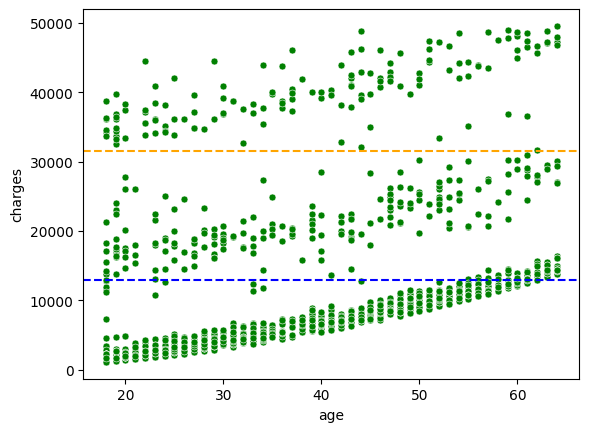

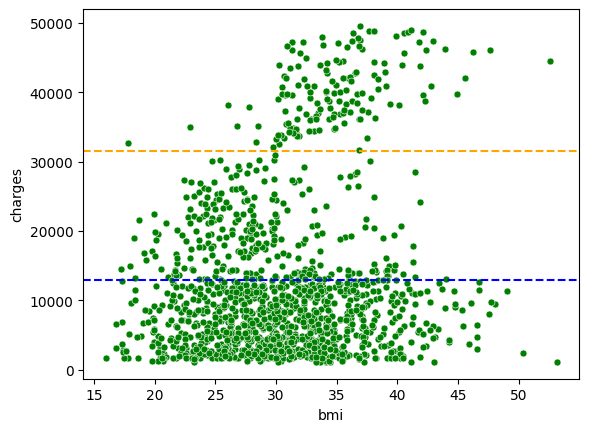

In [90]:
# Create a scatter plot
var = ['age',	'bmi']
for i in var:
  sns.scatterplot(data = df, x = i , y= 'charges', color= 'green', s=25)
  plt.axhline(y=13000, color='b', linestyle='--')
  plt.axhline(y=31500, color='orange', linestyle='--')
  plt.show()


We detect non-linear relation for bmi.

# White test

In [91]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import scipy.stats as stats

dfn = 12  # degrees of freedom for the numerator
dfd = 985  # degrees of freedom for the denominator
alpha = 0.05
critical_value = stats.f.ppf(1 - alpha, dfn, dfd)

tX_train = sm.add_constant(tX_train)
model = "tY_train ~ tX_train"
results = sm.formula.ols(model, data=X).fit(cov_type='HC3')

white_test = sm.stats.diagnostic.het_white(results.resid, results.model.exog)

print("LM Statistic:", white_test[0])
print("LM-Test p-value:", white_test[1])
print("F-statistics:", white_test[2])
print("F-Stat p-value:", white_test[3])

if (abs(white_test[2]) >= critical_value):
  print("We reject H0, so there is heteroscedastisity")
else:
  print("We accept H0, so there is no heteroscedastisity")


LM Statistic: 111.79494605745712
LM-Test p-value: 1.3168994382402596e-07
F-statistics: 2.6687775945613263
F-Stat p-value: 3.93325201619919e-08
We reject H0, so there is heteroscedastisity


We need to try either weighted regression or log-form.

## White test for log-lin model

In [92]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white
import scipy.stats as stats

dfn = 12  # degrees of freedom for the numerator
dfd = 985  # degrees of freedom for the denominator
alpha = 0.05
critical_value = stats.f.ppf(1 - alpha, dfn, dfd)
tY_train = np.log(tY_train)

X = sm.add_constant(tX_train)
model = "tY_train ~ X"
results = sm.formula.ols(model, data=X).fit(cov_type='HC3')


white_test = sm.stats.diagnostic.het_white(results.resid, results.model.exog)

print("LM Statistic:", white_test[0])
print("LM-Test p-value:", white_test[1])
print("F-statistics:", white_test[2])
print("F-Stat p-value:", white_test[3])

if (abs(white_test[2]) >= critical_value):
  print("We reject H0, so there is heteroscedastisity")
else:
  print("We accept H0, so there is no heteroscedastisity")


LM Statistic: 122.94913424262334
LM-Test p-value: 3.6584581075230447e-09
F-statistics: 2.9724640495338535
F-Stat p-value: 6.949238672476054e-10
We reject H0, so there is heteroscedastisity


In [93]:

dfn = 12  # degrees of freedom for the numerator
dfd = 985  # degrees of freedom for the denominator
alpha = 0.05
critical_value = stats.f.ppf(1 - alpha, dfn, dfd)
tY_train = np.log(tY_train)
X = sm.add_constant(tX_train)
X['bmi'] = np.log(tX_train['bmi'])
X['age'] = np.log(tX_train['age'])

model = "tY_train ~ X"
results = sm.formula.ols(model, data=X).fit(cov_type='HC3')

white_test = het_white(results.resid, results.model.exog)
print("LM Statistic:", white_test[0])
print("LM-Test p-value:", white_test[1])
print("F-statistics:", white_test[2])
print("F-Stat p-value:", white_test[3])
if (abs(white_test[2]) >= critical_value):
  print("We reject H0, so there is heteroscedastisity")
else:
  print("We accept H0, so there is no heteroscedastisity")


LM Statistic: 141.9717939138122
LM-Test p-value: 1.0082887222796788e-11
F-statistics: 3.4287567876066603
F-Stat p-value: 7.796947255798189e-13
We reject H0, so there is heteroscedastisity


## White test for WLS

In [94]:
import statsmodels.api as sm

X = sm.add_constant(tX_train)
model = sm.OLS(tY_train, X)

results = model.fit()
residuals = results.resid

sample_variance = np.var(residuals, ddof=1)
weights = 1 / sample_variance
X = sm.add_constant(tX_train)
model = sm.WLS(tY_train, X, weights=weights)

results = model.fit()
print(results.summary())


                            WLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            WLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     333.7
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          2.37e-292
Time:                        20:51:01   Log-Likelihood:                 1549.3
No. Observations:                 998   AIC:                            -3079.
Df Residuals:                     988   BIC:                            -3030.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9164      0.032  

In [95]:
import numpy as np
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.diagnostic import het_white
import scipy.stats as stats

dfn = 12  # degrees of freedom for the numerator
dfd = 985  # degrees of freedom for the denominator
alpha = 0.05
critical_value = stats.f.ppf(1 - alpha, dfn, dfd)

X = sm.add_constant(tX_train)
model = "tY_train ~ tX_train"
results = sm.formula.wls(model, data=tX_train, weights = weights ).fit(cov_type='HC3')

white_test = sm.stats.diagnostic.het_white(results.resid, results.model.exog)

print("LM Statistic:", white_test[0])
print("LM-Test p-value:", white_test[1])
print("F-statistics:", white_test[2])
print("F-Stat p-value:", white_test[3])

if (abs(white_test[2]) >= critical_value):
  print("We reject H0, so there is heteroscedastisity")
else:
  print("We accept H0, so there is no heteroscedastisity")


LM Statistic: 158.07964623425616
LM-Test p-value: 1.718823230188651e-14
F-statistics: 3.981642691616568
F-Stat p-value: 4.692862005934898e-16
We reject H0, so there is heteroscedastisity


# Models with devision based on income


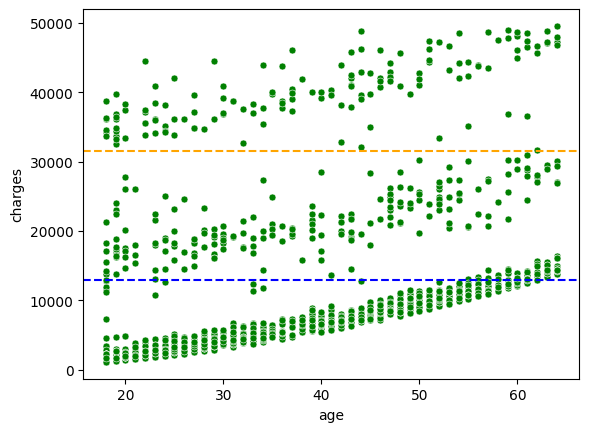

In [96]:
df = df[lambda x: x.charges <= 50000]
df['bmi_squared'] = df['bmi'] ** 2
sns.scatterplot(data = df, x = 'age' , y= 'charges', color= 'green', s=25)
plt.axhline(y=13000, color='b', linestyle='--')
plt.axhline(y=31500, color='orange', linestyle='--')
plt.show()

We decided how to divide data for future separate models based on this plot

In [97]:
df = df.drop('region', axis =1)

In [98]:
df1 = df[lambda x: x.charges <= 13000]
df2 = df[(df['charges'] > 13000) & (df['charges'] <= 31500)]
df3 = df[lambda x: x.charges > 31500]

In [99]:
tX1, tY1 = df1.drop('charges', axis=1), df1.charges
tX2, tY2 = df2.drop('charges', axis=1), df2.charges
tX3, tY3 = df3.drop('charges', axis=1), df3.charges

In [100]:
tX1 = pd.get_dummies(tX1, columns = ['sex', 'smoker'], drop_first = True)
tX2 = pd.get_dummies(tX2, columns = ['sex', 'smoker'], drop_first = True)
tX3 = pd.get_dummies(tX3, columns = ['sex', 'smoker'], drop_first = True)

In [101]:
from sklearn.model_selection import train_test_split

tX1_train, tX1_valid, tY1_train, tY1_valid = (
    train_test_split(tX1, tY1, test_size=0.25, random_state=12000)
)

tX2_train, tX2_valid, tY2_train, tY2_valid = (
    train_test_split(tX2, tY2, test_size=0.25, random_state=12000)
)

tX3_train, tX3_valid, tY3_train, tY3_valid = (
    train_test_split(tX3, tY3, test_size=0.25, random_state=12000)
)

### DF1

In [102]:
from statsmodels.api import OLS
X = sm.add_constant(tX1_train)
OLS(tY1_train,X).fit(cov_type='HC3').summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     969.0
Date:                Sun, 10 Dec 2023   Prob (F-statistic):          4.27e-304
Time:                        20:51:04   Log-Likelihood:                -5695.7
No. Observations:                 677   AIC:                         1.140e+04
Df Residuals:                     671   BIC:                         1.143e+04
Df Model:                           5                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2743.6172    610.970     -4.491      0.000   -3941.095   -1546.139
age           246.6456      3.972     62.094      0.000     238.860     254.431
bmi           -21.6705     39.570     -0.548      0.584     -99.227      55.886
children      422.6400     27.098     15.597      0.000     369.529     475.751
bmi_squared     0.4369      0.620      0.705      0.481      -0.777       1.651
sex_male     -345.9427     84.658     -4.086      0.000    -511.870    -180.016
smoker_yes           0          0        nan        nan           0           0
==============================================================================
Omnibus:                      864.363   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            94881.015
Skew:                           6.563   Prob(JB):                         0.00
Kurtosis:                      59.492   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### DF2

In [103]:
from statsmodels.api import OLS
X = sm.add_constant(tX2_train)
OLS(tY2_train, tX2_train).fit(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                charges   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              746.5
Date:                Sun, 10 Dec 2023   Prob (F-statistic):                   2.22e-135
Time:                        20:51:04   Log-Likelihood:                         -2065.7
No. Observations:                 209   AIC:                                      4143.
Df Residuals:                     203   BIC:                                      4163.
Df Model:                           6                                                  
Covariance Type:                  HC3                                                  
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age            29.5915     24.402      1.213      0.225     -18.235      77.418
bmi          1018.9154    134.365      7.583      0.000     755.564    1282.267
children      493.7025    257.346      1.918      0.055     -10.686     998.091
bmi_squared   -15.6585      3.371     -4.645      0.000     -22.266      -9.051
sex_male      477.9742    697.352      0.685      0.493    -888.811    1844.760
smoker_yes   3298.6772    899.936      3.665      0.000    1534.834    5062.520
==============================================================================
Omnibus:                       21.165   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.975
Skew:                           0.745   Prob(JB):                     1.69e-05
Kurtosis:                       2.447   Cond. No.                     2.30e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
[3] The condition number is large, 2.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### DF3

In [104]:
X = sm.add_constant(tX3_train)
OLS(tY3_train,X).fit(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     336.8
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           9.53e-66
Time:                        20:51:04   Log-Likelihood:                -962.34
No. Observations:                 111   AIC:                             1939.
Df Residuals:                     104   BIC:                             1958.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9155.2772   4925.190      1.859      0.063    -497.918    1.88e+04
age           267.3721      6.449     41.458      0.000     254.732     280.012
bmi           159.5312    231.990      0.688      0.492    -295.160     614.222
children      381.5032    126.400      3.018      0.003     133.763     629.244
bmi_squared     3.9682      2.859      1.388      0.165      -1.636       9.572
sex_male     -863.2109    319.976     -2.698      0.007   -1490.352    -236.070
smoker_yes   1.067e+04   2029.430      5.260      0.000    6696.659    1.47e+04
==============================================================================
Omnibus:                       31.213   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              403.929
Skew:                           0.164   Prob(JB):                     1.94e-88
Kurtosis:                      12.340   Cond. No.                     3.97e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 3.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""